In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats

The following data is from a Kaggle competition to most accurately correct Housing prices from a training data set and a test data set.

In [2]:
raw_data = pd.read_csv(r'C:\Users\chase\Anaconda3\Database_Dictionary\Kaggle\House_Prices\train.csv')
raw_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Our dependant variable here is the SalePrice.  First we need to check SalePrice distribution, as linear models like normally distributed data.

C:\Users\chase\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


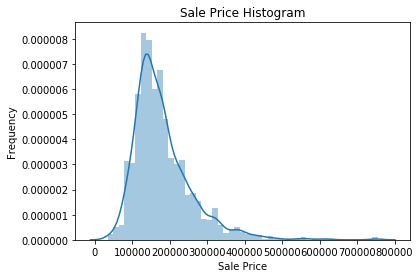

In [3]:
hist = sns.distplot(raw_data['SalePrice'])
plt.title('Sale Price Histogram')
plt.ylabel('Frequency')
plt.xlabel("Sale Price")
plt.show()


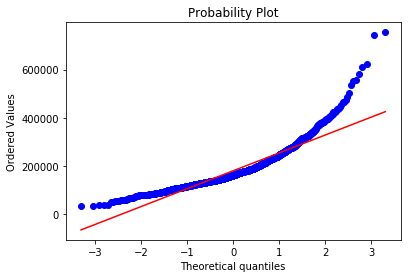

In [4]:
res = stats.probplot(raw_data['SalePrice'], plot=plt)
plt.show()

Our dependant variable is right skewed, so we therefore need to transform it to try to get it more normally distributed.  This looks like a candidate for a log transformation  

C:\Users\chase\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


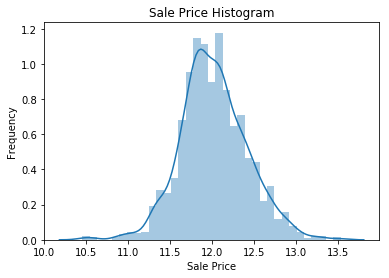

In [5]:
raw_data['logSalePrice'] = raw_data['SalePrice'].apply(np.log)
hist = sns.distplot(raw_data['logSalePrice'])
plt.title('Sale Price Histogram')
plt.ylabel('Frequency')
plt.xlabel("Sale Price")
plt.show()

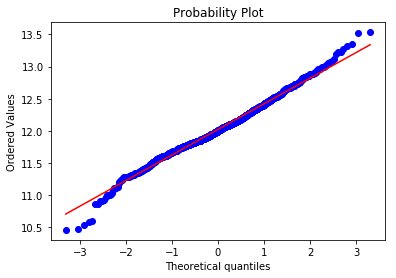

In [6]:
res = stats.probplot(raw_data['logSalePrice'], plot=plt)
plt.show()

This looks better.  The transformed Sale Price is more normally distributed and should work better in our models.  Let's describe our outcome variable to make sure there isn't anything crazy going on.

In [7]:
raw_data['logSalePrice'].describe()

count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: logSalePrice, dtype: float64

In [8]:
raw_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Nope the data doesn't look abnormal, such as extra zeroes on our max or a negative min.  Our next step will evaluating our features for feature selection.  I first like to look over and see if any don't make sense in the model.  I then like to look for colinearity which can skew our results as well.  The seaborn heatmap is great for this.  

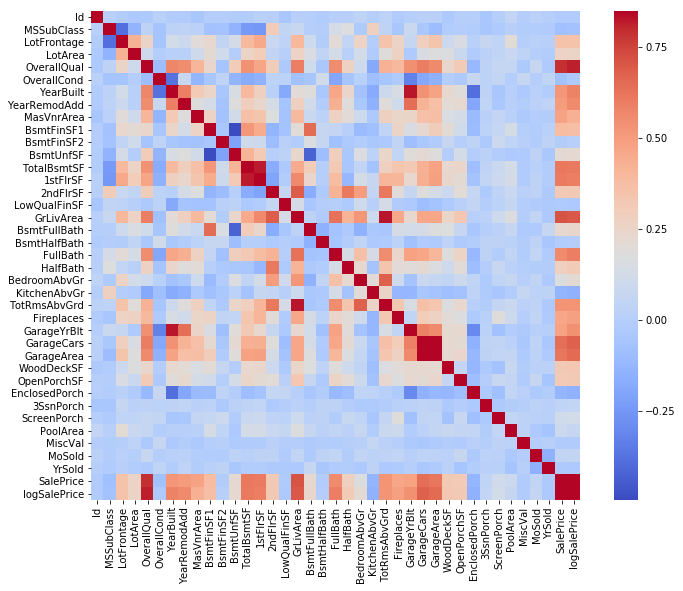

In [9]:
f, ax = plt.subplots(figsize=(12, 9))
x = sns.heatmap(raw_data.corr(), cmap='coolwarm', square=True, vmax=0.85)


A couple of strong correlations appear here.  Firstly, OverallQual is strongly correlated with SalePrice.  OverallQual is a subjective variable, and one we are not interested in predicting so we'll drop the variable.

TotRmsAbvGrd and GrLivArea are strongly correlated and GarageCars and GarageArea are strongly correlated.  One of the assumptions of linear regression is the absence of multicollinearity in a datasets independent variables.  Therefore I will keep the variable between these that is more strongly correlated with SalePrice

In [10]:
raw_data = raw_data.drop(columns=['OverallQual'])

In [11]:
raw_data[['SalePrice','TotRmsAbvGrd', 'GrLivArea', 'GarageCars', 'GarageArea']].corr()

,SalePrice,TotRmsAbvGrd,GrLivArea,GarageCars,GarageArea
SalePrice,1.000000,0.533723,0.708624,0.640409,0.623431
TotRmsAbvGrd,0.533723,1.000000,0.825489,0.362289,0.337822
GrLivArea,0.708624,0.825489,1.000000,0.467247,0.468997
GarageCars,0.640409,0.362289,0.467247,1.000000,0.882475
GarageArea,0.623431,0.337822,0.468997,0.882475,1.000000


GrLivArea is more correlated with SalePrice than TotRmsAbvGrd and GarageCars is more correlated with Sale Price than GarageArea.

In [12]:
#Dropping TotRmsAbvGrd and GarageArea
raw_data = raw_data.drop(columns=['TotRmsAbvGrd', 'GarageArea'])

Next, I like to make a number of scatter plots to look at any potential outliers and why they may or may not need to be addressed.  When questions come up later in my analysis I can refer to these plots as well.

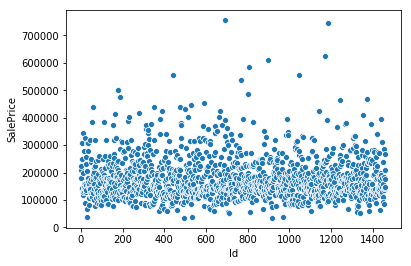

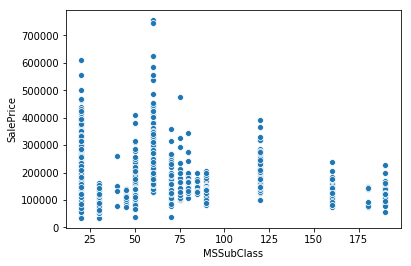

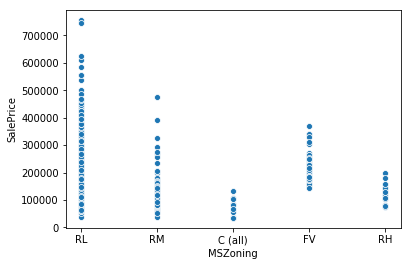

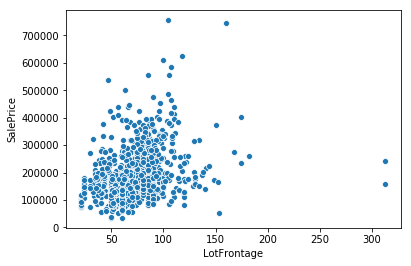

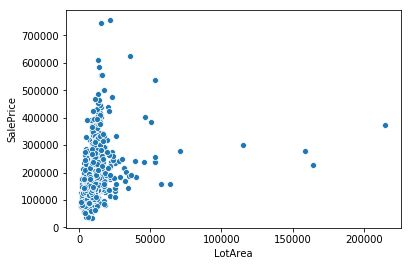

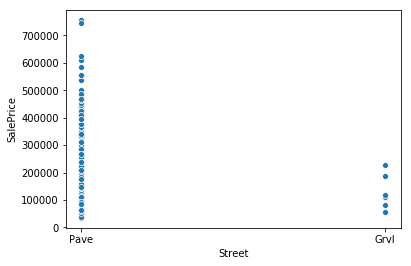

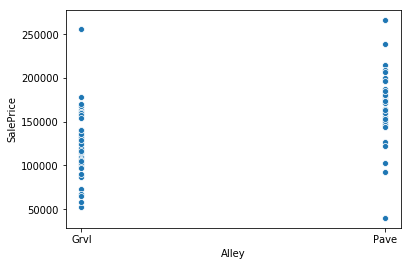

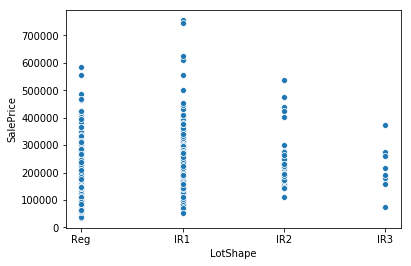

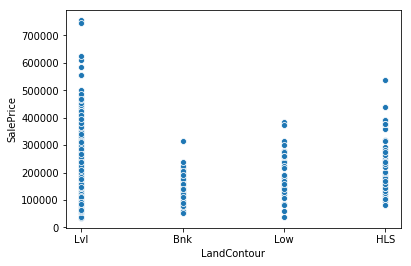

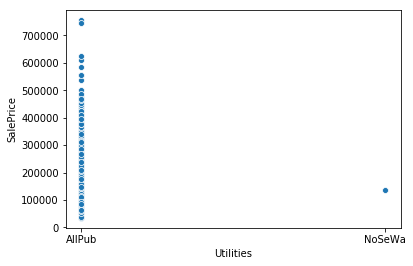

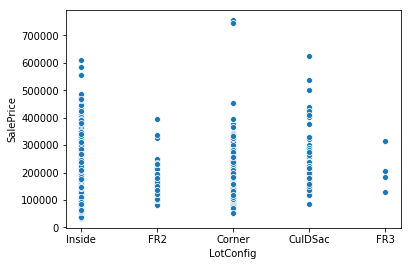

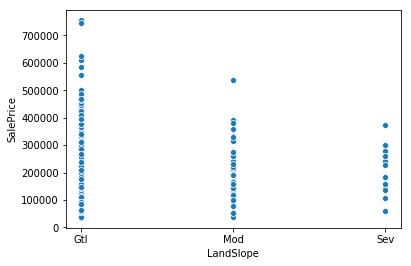

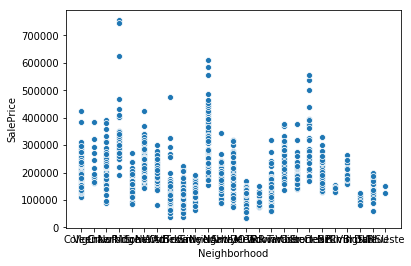

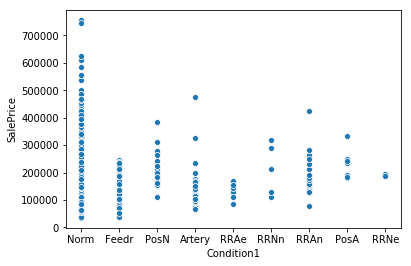

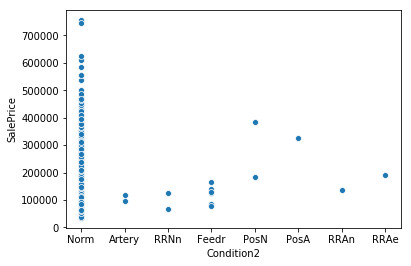

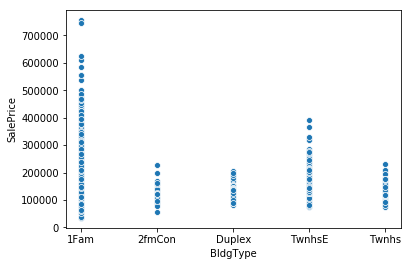

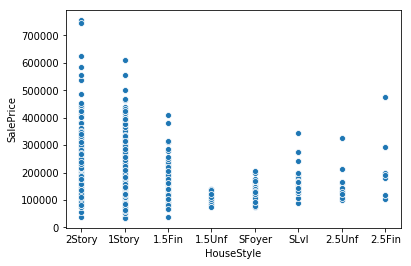

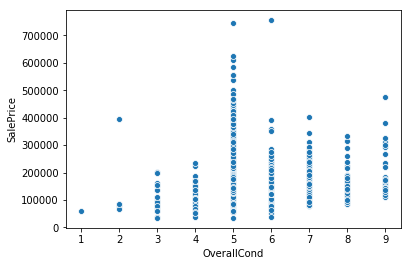

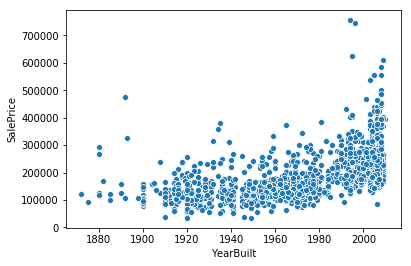

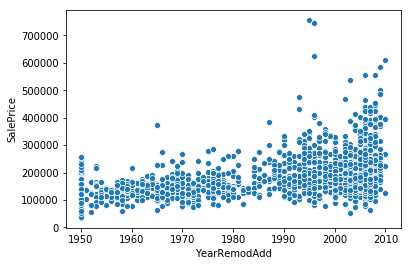

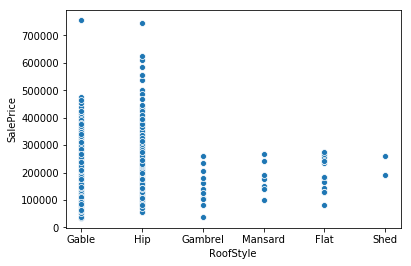

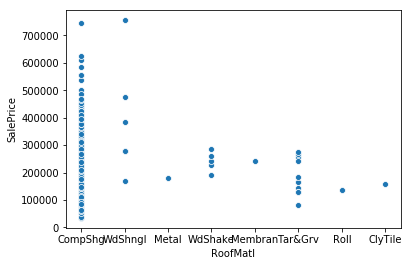

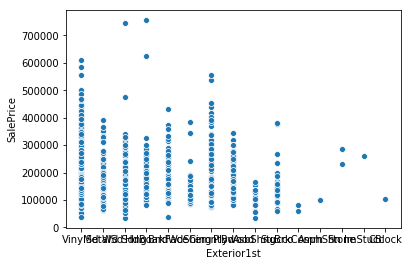

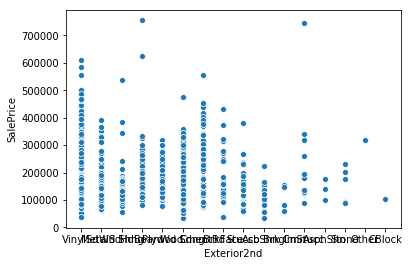

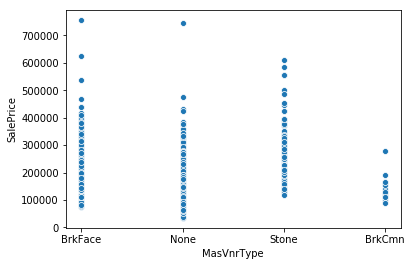

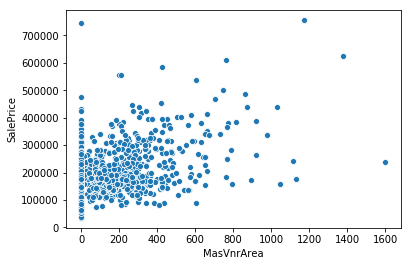

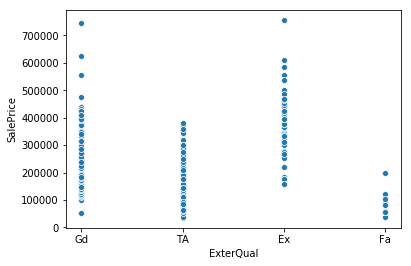

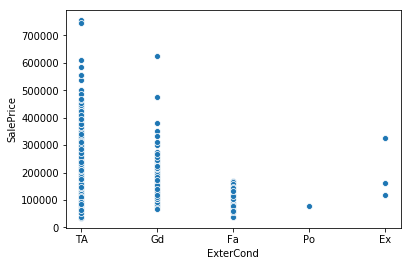

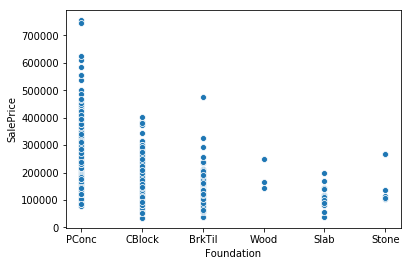

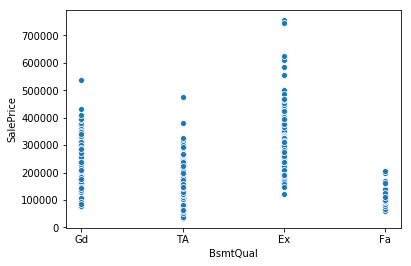

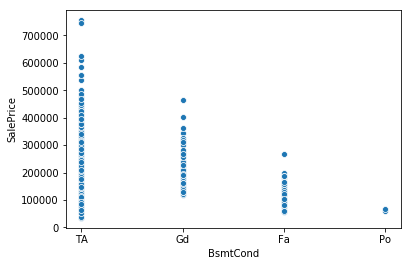

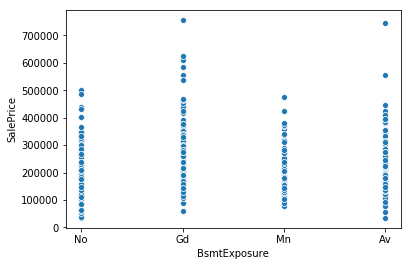

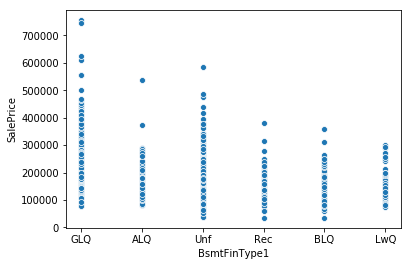

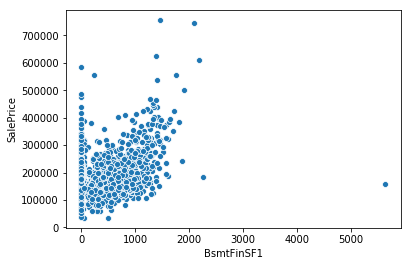

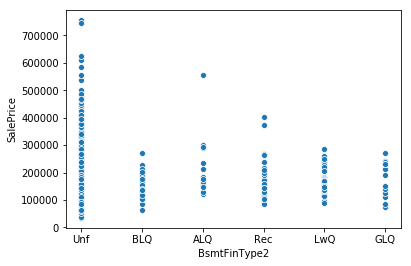

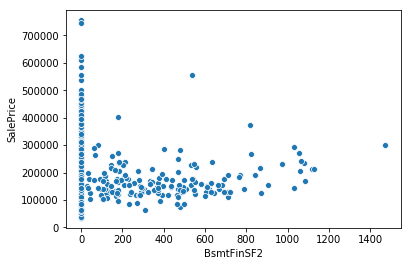

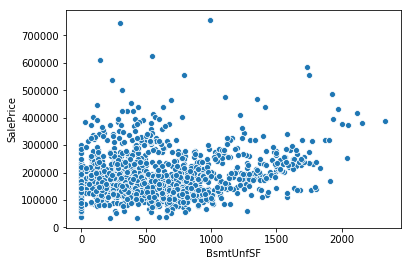

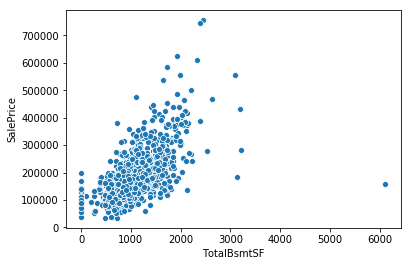

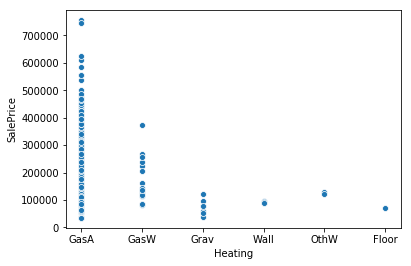

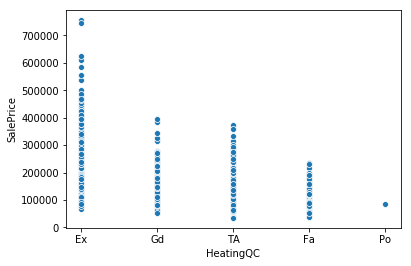

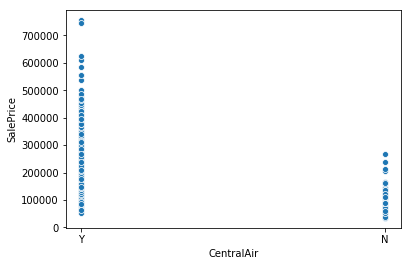

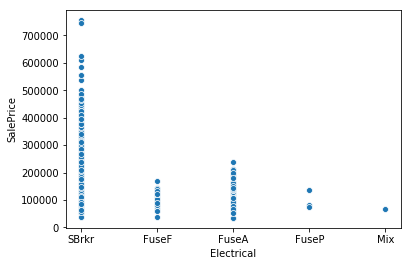

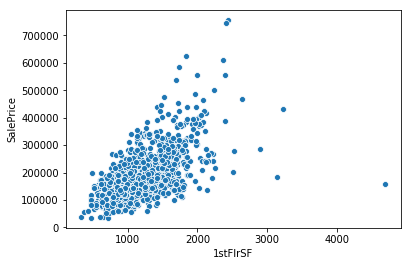

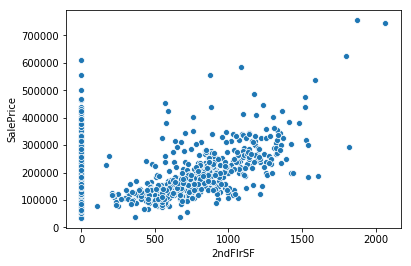

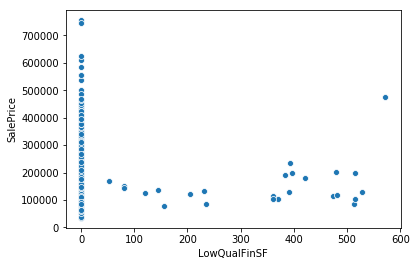

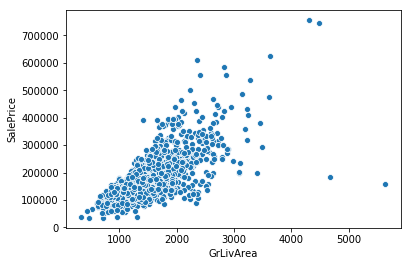

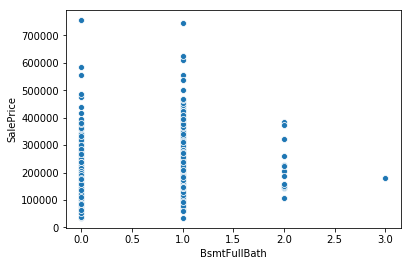

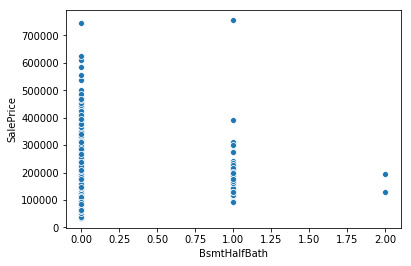

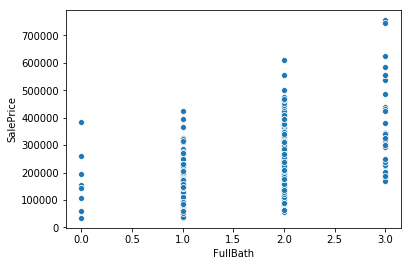

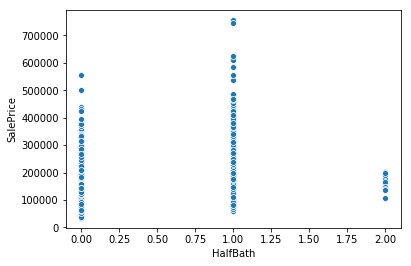

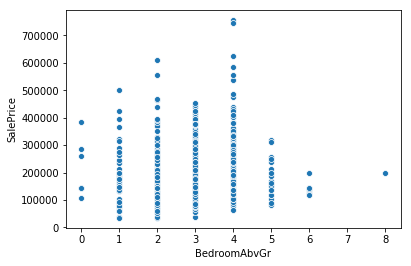

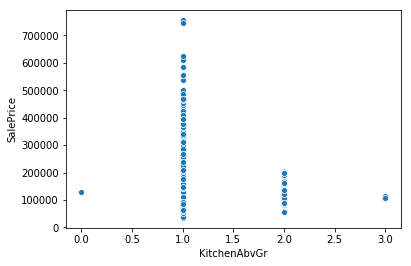

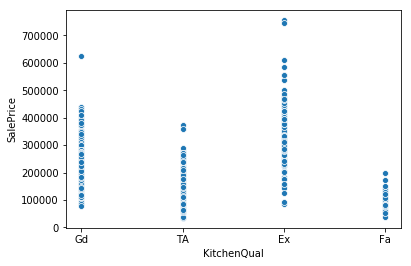

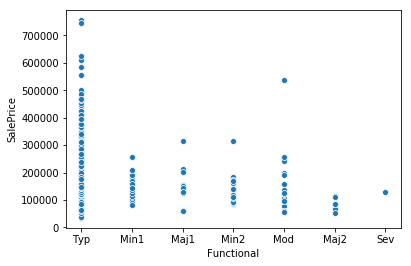

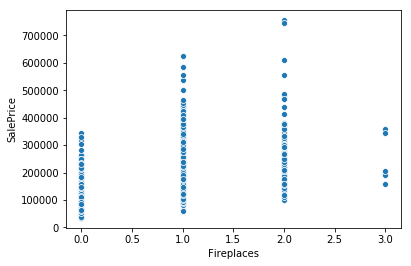

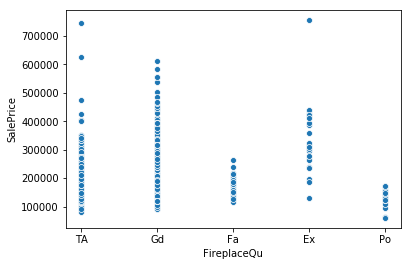

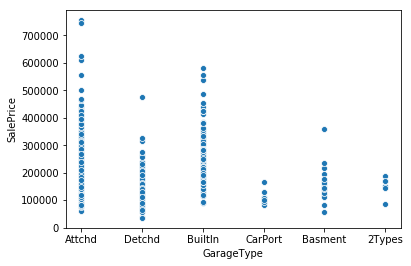

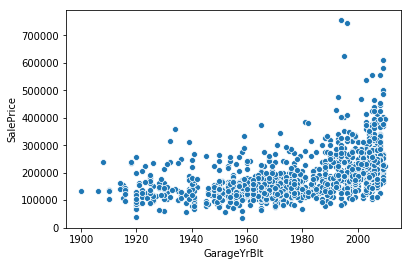

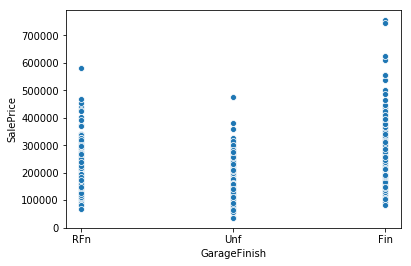

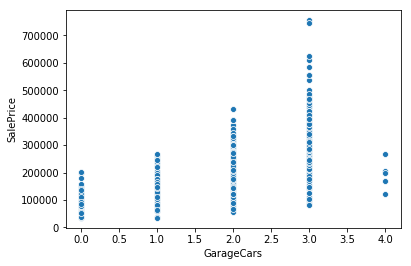

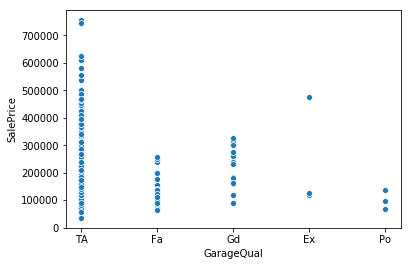

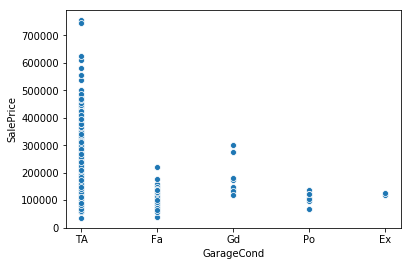

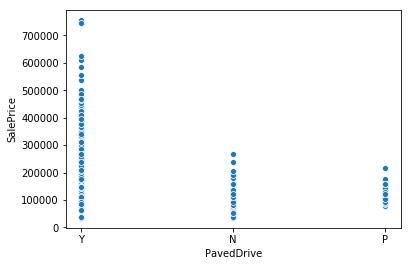

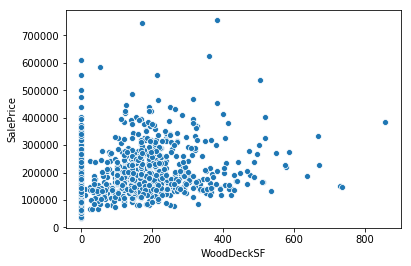

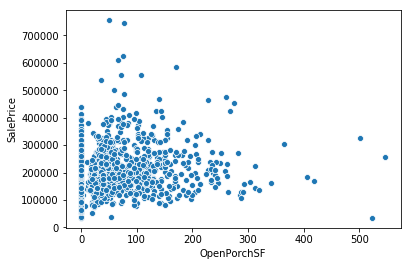

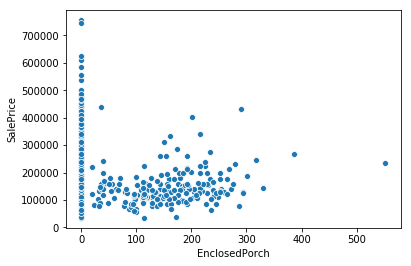

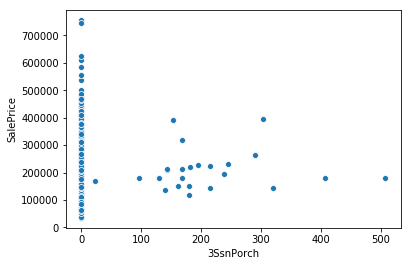

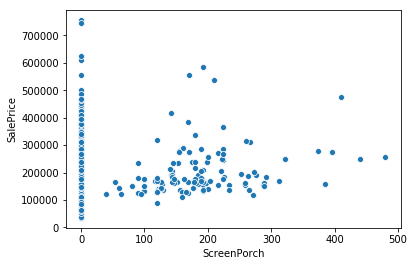

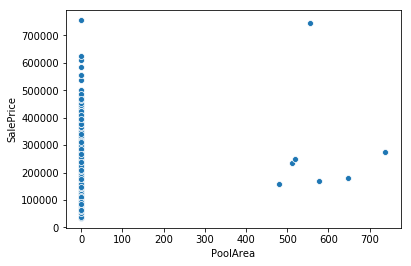

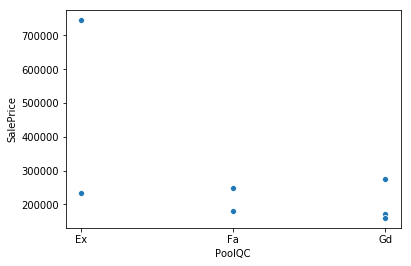

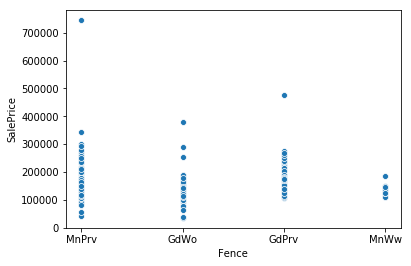

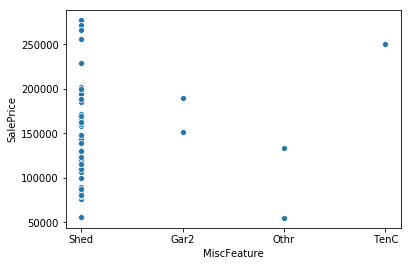

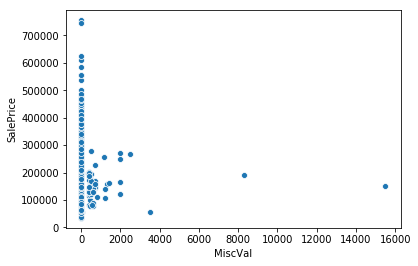

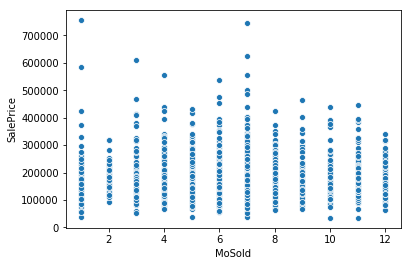

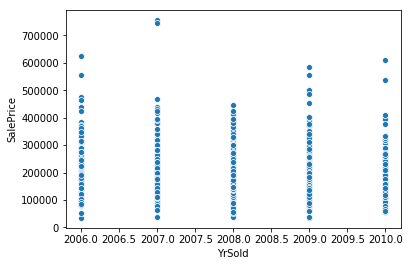

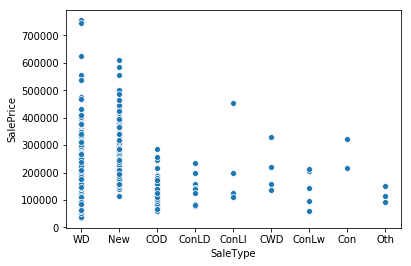

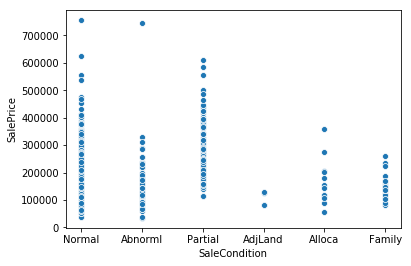

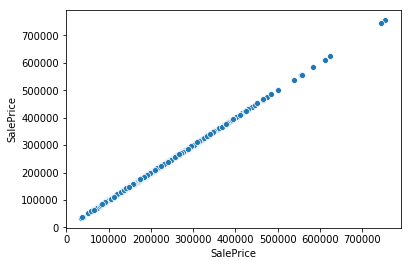

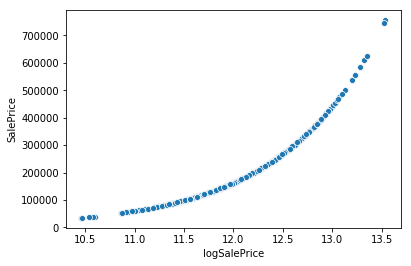

In [13]:
for i in list(raw_data.columns):
    sns.scatterplot(x=raw_data[i], y=raw_data['SalePrice'])
    plt.show()

Checking our null values, I'll plot the total missing values per feature and also the percent missing from the dataframe before checking the metadata for some direction on how to address the null values on a feature to feature basis.

In [15]:
data = pd.DataFrame(data=raw_data.isnull().sum(), columns=['Total']).sort_values(by=['Total'], ascending=False)
data2 = pd.DataFrame(data=(raw_data.isnull().sum())/raw_data.shape[0], columns=['Percent']).sort_values(by=['Percent'], ascending=False)
data = pd.concat([data, data2], axis=1)
data[:19]

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageFinish,81,0.055479


PoolQC has 99% missing values, so dropping it and keeping PoolArea would be beneficial.  After looking at PoolArea vs SalePrice however, there is no linear relationship and 99% of the houses do not have pools.  We'll drop both PoolArea and PoolQC.

MiscFeature, Alley, Fence, and FireplaceQu all have greater than 48% missing values, but this is because these houses don't have those features according to the metadata.  I'll replace the NaN with a None value.  

In [16]:
raw_data = raw_data.drop(columns=['PoolArea', 'PoolQC'])

In [17]:
raw_data[['MiscFeature', 'Alley', 'Fence', 'FireplaceQu']] = raw_data[['MiscFeature', 'Alley', 'Fence', 'FireplaceQu']].fillna('None')

LotFrontage is missing significant data as well, but it cannot be explained in the metadata.  So we can either remove the NaN rows, remove the LotFrontage column, or fill the NaN values.  LotFrontage has linear relationship with SalePrice so we will try to minimize data loss.

We can replace the NaN values with an average of LotFrontage of some other houses.  Getting even more precise, we can take the average of houses in the same neighborhood.

In [18]:
raw_data['LotFrontage'] = raw_data.groupby(['Neighborhood'])['LotFrontage'].apply(lambda x: x.fillna(x.mean()))

Next filling NaN for ['GarageType', 'GarageQual', 'GarageCond', 'GarageFinish'] with None because that is how its listed in the metadata.

In [19]:
# GarageType
raw_data[['GarageType', 'GarageQual', 'GarageCond', 'GarageFinish', 'GarageYrBlt']] = raw_data[['GarageType', 'GarageQual', 'GarageCond', 'GarageFinish', 'GarageYrBlt']].fillna('None')

Next filling NaN for ['BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtQual', 'BsmtFinType1'] with None because that is how its listed in the metadata.

In [20]:
raw_data[['BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtQual', 'BsmtFinType1']] = raw_data[['BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtQual', 'BsmtFinType1']].fillna('None')

Next because there are 8 ['MasVnrType', 'MasVnrArea', 'Electrical'] that are missing that cannot be explained in the metadata.  Because these are categorical I cannot replace them with a logical mean or number and because there are only 8 data points I will drop these points.    

In [21]:
#Quick check that our dataframe is where it needs to be
data = pd.DataFrame(data=raw_data.isnull().sum(), columns=['Total']).sort_values(by=['Total'], ascending=False)
data2 = pd.DataFrame(data=(raw_data.isnull().sum())/raw_data.shape[0], columns=['Percent']).sort_values(by=['Percent'], ascending=False)
data = pd.concat([data, data2], axis=1)
data[:19]

,Total,Percent
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685
BedroomAbvGr,0,0.000000
FireplaceQu,0,0.000000
Fireplaces,0,0.000000
Functional,0,0.000000
KitchenQual,0,0.000000
KitchenAbvGr,0,0.000000
HalfBath,0,0.000000


In [22]:
raw_data.dropna(axis=0, inplace=True)

Now that the null values are dealt with, we'll convert all continuous data to float64 and put them in a seperate dataframe that I will concatenate later.

Looking over the metadata we have some features that are more like categorical features such as ['OverallCond', 'MSSubClass', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars'].

['GarageYrBlt', 'YearBuilt', 'YearRemodAdd', 'MoSold', 'YrSold'] are time series features currently saved as floats.  Because time series can get tricky, for our purposes we will treat these as categorical.

Linear models cannot handle categorical data.  Luckily, pandas has the nifty pandas.get_dummies() function that will convert categorical data to a series of binary 1s, and 0s, that can be fed into a linear model.

In [23]:
a=[]
for i in raw_data:
    if raw_data[i].dtype == 'object':
        a.append(i)
        
dummy_df = raw_data[a]

In [24]:
categ = raw_data[['OverallCond', 'MSSubClass', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars']].astype(object)

In [25]:
dummy_df = pd.concat([dummy_df, categ], axis=1)

In [26]:
raw_data = raw_data.drop(columns=['OverallCond', 'MSSubClass', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars'])

In [27]:
dummy_df = pd.get_dummies(dummy_df)

In [28]:
d=[]
for i in raw_data:
    if raw_data[i].dtype == ('int64'):
        d.append(i)
    elif raw_data[i].dtype == ('float64'):
        d.append(i)

numbers = raw_data[d]

numbers = numbers.astype(float)

In [29]:
df = pd.concat([numbers, dummy_df], axis=1)

Now that we have our dataframe cleaned and categorical variables in binary we are ready to model.

In [101]:
# Setting the X_train and Y_train
X_train = df.drop(columns=['SalePrice', 'logSalePrice'])
Y_train = df['SalePrice']

In [102]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [103]:
#setting up training and test groups for evaluation
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.3)

In [104]:
#setting up normalized training group and scaled testing group to evaluate if normalized data will increase accuracy.
from sklearn.preprocessing import normalize, scale

normalize_X = normalize(X_train)

scale_X = scale(X_train)

Seeing which algorithm works best with the data:

In [136]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100)

rfr.fit(X_train, Y_train)

print('Random Forest Regressor R^2 score of:', rfr.score(X_train, Y_train))

Random Forest Regressor R^2 score of: 0.9759897553773238


In [117]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()

gbr.fit(X_train, Y_train)

print('Gradient Boodting Regressor R^2 score of:', gbr.score(X_train, Y_train))

Gradient Boodting Regressor R^2 score of: 0.968203935004949


In [120]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=.01, max_iter=10000000)

ridge.fit(X_train, Y_train)

print('Ridge Regression R^2 score of:', ridge.score(X_train, Y_train))

Ridge Regression R^2 score of: 0.9363663314517626


In [124]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1, max_iter=10000)

lasso.fit(X_train, Y_train)

print('Lasso Regression R^2 score of:', lasso.score(X_train, Y_train))

Lasso Regression R^2 score of: 0.9363451918877547


In [125]:
#Testing the best perfomer, Random Forest Regressor
cross_val_score(rfr, X_train, Y_train, cv=5)

array([0.86046267, 0.82003385, 0.90148379, 0.85597698, 0.79420757])

The Random Forest Regressor performed the best so we will use this model to validate.  The Cross-Validation scores showed high accuracy and precision.  Will test whether normalized/scaled continous data helps prediction.

In [90]:
cross_val_score(rfr, X_train, Y_train, cv=5)

array([0.87427926, 0.83596403, 0.80123077, 0.84603314, 0.7901961 ])

In [137]:
print('Random Forest Scores:')

print('Random Forest Regressor R^2 score of non-normalized X_train:', rfr.score(X_train, Y_train))

rfr.fit(normalize_X, Y_train)

print('Random Forest Regressor R^2 score of normalized X_train:', rfr.score(normalize_X, Y_train))

rfr.fit(scale_X, Y_train)

print('Random Forest Regressor R^2 score of scaled X_train:', rfr.score(scale_X, Y_train))

Random Forest Scores:
Random Forest Regressor R^2 score of non-normalized X_train: 0.9759897553773238
Random Forest Regressor R^2 score of normalized X_train: 0.9647734544073123
Random Forest Regressor R^2 score of scaled X_train: 0.9767447656237503


The normalized data performs worse than the others.  The non-normalized data and the scaled X_train perform about the same, and because of this we will model with the non-normalized data.  Now we'll check the explained variance and the R^2 score between the Y_pred and Y_train labels.    

In [143]:
rfr.fit(X_train, Y_train)
Y_pred = rfr.predict(X_test)

print('Explained variance between Y_pred and Y_test:',metrics.explained_variance_score(Y_pred, Y_test))
print('R^2 score between Y_pred and Y_test:', metrics.r2_score(Y_pred, Y_test))


Explained variance between Y_pred and Y_test: 0.7915362617935943
R^2 score between Y_pred and Y_test: 0.7865315164890204


## Considerations for model improvement:
* I could try to transform some of the continuous data to have an even more linear relationship to SalePrice which may improve performance.
* Increased feature engineering for more explanatory features
* Could try to implement time series analysis
* Other features such as wine price, wine brand, grape types
* More data, this dataset only had about 1400 datapoints.

## Limitations:
* Model did not use time series.  
* Getting all of these features may not be efficient.  A model that can predict well but with less features may be more practical.
* Not sure where the data came from, this model may not be as effective predicting housing prices in other areas.  